In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from datetime import datetime
# ----------------------------
# 1. Data Loading and Preprocessing
# ----------------------------
df = pd.read_csv('weekly_df_with_tickers.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=['mvel1'])

# ----------------------------
# 2. Define the Rolling Window Forecasting Function with Validation (no monthly R²)
# ----------------------------
def rolling_window_forecast_with_validation(df, base_model, initial_train_start, initial_train_end,
                                              validation_window_years=1, rolling_step=1, update_threshold=2019):
    """
    Performs rolling window forecasting with a dedicated validation period for hyperparameter tuning.

    For each iteration:
      - The training period runs from train_start to train_end.
      - The validation period immediately follows (with a length of validation_window_years
        or until the maximum available date, if the window is incomplete).
      - If the validation period's start year is less than update_threshold (here 2019),
        hyperparameter tuning is performed (via GridSearchCV) on the training data.
      - Otherwise, the previously tuned hyperparameters are used.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the data (must have a DateTimeIndex).
    base_model : scikit-learn regressor
        The base model (e.g., RandomForestRegressor).
    initial_train_start : str or datetime
        Start date for the initial training period.
    initial_train_end : str or datetime
        End date for the initial training period.
    validation_window_years : int, default=1
        Length (in years) of the validation period.
    rolling_step : int, default=1
        Number of years to shift the window for each iteration.
    update_threshold : int
        Hyperparameter tuning is performed if the validation period's start year is less than this threshold.

    Returns:
    --------
    results : list of dicts
        Each dict contains the window’s training/validation dates, performance metrics,
        and the hyperparameters used.
    """
    results = []
    best_params = None  # To store the tuned hyperparameters

    # Convert dates to Timestamps.
    train_start = pd.to_datetime(initial_train_start)
    train_end = pd.to_datetime(initial_train_end)
    val_start = train_end + pd.DateOffset(days=1)
    val_end = val_start + pd.DateOffset(years=validation_window_years) - pd.DateOffset(days=1)

    max_date = df.index.max()

    # Define feature columns (exclude target and ticker)
    non_feature_cols = ['risk_premium', 'Ticker']
    feature_cols = [col for col in df.columns if col not in non_feature_cols]

    while train_start < max_date:
        # If the planned validation end exceeds available data, adjust it.
        if val_end > max_date:
            val_end = max_date

        # Extract training and validation data for the current window.
        train_data = df.loc[(df.index >= train_start) & (df.index <= train_end)]
        val_data = df.loc[(df.index >= val_start) & (df.index <= val_end)]
        if train_data.empty or val_data.empty:
            break

        X_train = train_data[feature_cols]
        y_train = train_data['risk_premium']
        X_val = val_data[feature_cols]
        y_val = val_data['risk_premium']

        # If the validation period starts before the update threshold, perform hyperparameter tuning.
        if val_start.year < update_threshold:
            param_grid = {
                'n_estimators': [50, 100, 150],
                'max_depth': [3, 5, 7, None]
            }
            grid = GridSearchCV(estimator=base_model, param_grid=param_grid,
                                scoring='r2', cv=3, n_jobs=-1)
            grid.fit(X_train, y_train)
            best_params = grid.best_params_
            model_tuned = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
            model_tuned.fit(X_train, y_train)
            y_pred = model_tuned.predict(X_val)
            tuning_info = f"Tuned: {best_params}"
        else:
            # For validation periods starting in or after the update threshold, use the previously tuned parameters.
            if best_params is not None:
                model_tuned = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
                model_tuned.fit(X_train, y_train)
                y_pred = model_tuned.predict(X_val)
                tuning_info = f"Using best_params: {best_params}"
            else:
                # Fallback: if no tuning was done previously, use the base model.
                base_model.fit(X_train, y_train)
                y_pred = base_model.predict(X_val)
                tuning_info = "No tuning performed"

        overall_r2 = r2_score(y_val, y_pred)

        results.append({
            'train_start': train_start,
            'train_end': train_end,
            'val_start': val_start,
            'val_end': val_end,
            'overall_r2': overall_r2,
            'best_params': best_params,
            'tuning_info': tuning_info
        })

        print(f"Train: {train_start.date()} to {train_end.date()} | "
              f"Validation: {val_start.date()} to {val_end.date()} | "
              f"Overall R^2: {overall_r2:.4f} | {tuning_info}")

        # Update the window by shifting each boundary forward by rolling_step years.
        train_start += pd.DateOffset(years=rolling_step)
        train_end += pd.DateOffset(years=rolling_step)
        val_start += pd.DateOffset(years=rolling_step)
        val_end += pd.DateOffset(years=rolling_step)

    return results

# ----------------------------
# 3. Model Initialization and Running the Forecast
# ----------------------------
# Define the base model (without fixed hyperparameters).
base_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Run the rolling window forecast with validation.
results = rolling_window_forecast_with_validation(
    df,
    base_model,
    initial_train_start='1990-01-01',
    initial_train_end='2015-12-31',
    validation_window_years=1,   # validation period of one year
    rolling_step=1,
    update_threshold=2019        # tune hyperparameters if validation period starts before 2019
)

# ----------------------------
# 4. Post-Processing
# ----------------------------
results_df = pd.DataFrame([{
    'train_start': r['train_start'],
    'train_end': r['train_end'],
    'val_start': r['val_start'],
    'val_end': r['val_end'],
    'overall_r2': r['overall_r2'],
    'best_params': r['best_params'],
    'tuning_info': r['tuning_info']
} for r in results])

print("\nSummary of Rolling Window Results with Validation:")
print(results_df)

# Save the results to a CSV file.
results_df.to_csv("rolling_window_results_with_validation.csv", index=False)

Train: 1990-01-01 to 2015-12-31 | Validation: 2016-01-01 to 2016-12-31 | Overall R^2: 0.2009 | Tuned: {'max_depth': 7, 'n_estimators': 150}
Train: 1991-01-01 to 2016-12-31 | Validation: 2017-01-01 to 2017-12-31 | Overall R^2: 0.1070 | Tuned: {'max_depth': 7, 'n_estimators': 50}
Train: 1992-01-01 to 2017-12-31 | Validation: 2018-01-01 to 2018-12-31 | Overall R^2: 0.1902 | Tuned: {'max_depth': None, 'n_estimators': 150}
Train: 1993-01-01 to 2018-12-31 | Validation: 2019-01-01 to 2019-12-31 | Overall R^2: 0.1768 | Using best_params: {'max_depth': None, 'n_estimators': 150}
Train: 1994-01-01 to 2019-12-31 | Validation: 2020-01-01 to 2020-12-31 | Overall R^2: -0.0693 | Using best_params: {'max_depth': None, 'n_estimators': 150}
Train: 1995-01-01 to 2020-12-31 | Validation: 2021-01-01 to 2021-12-31 | Overall R^2: 0.0167 | Using best_params: {'max_depth': None, 'n_estimators': 150}
Train: 1996-01-01 to 2021-12-31 | Validation: 2022-01-01 to 2022-12-31 | Overall R^2: 0.0634 | Using best_params

In [14]:
import pandas as pd
df1 = pd.read_csv('rolling_window_results_with_validation.csv')
df2 = pd.read_csv('NN1_performance_metrics.csv')
df3 = pd.read_csv('NN2_performance_metrics.csv')
df4 = pd.read_csv('r2_scores_linear.csv')
df4 = df4.iloc[:, :3]
df1 = df1.iloc[:,4 ]
df2=df2.iloc[:,1 ]
df3=df3.iloc[:,1 ]
combined_df = pd.concat([df4,df1, df2, df3], axis=1)

# 给新合并的列命名
combined_df.columns = ['Year','OLS3',	'OLS','RF','NN1','NN2']

# 保存为一个新的 CSV 文件
combined_df.to_csv('combined_file.csv', index=False)

,Year,OLS3,OLS,RF,NN1,NN2
0,2016,0.067801,0.077775,0.200939,0.282950,0.186601
1,2017,0.037389,0.000216,0.106976,0.151686,0.143949
2,2018,0.067037,0.062070,0.190167,0.052328,0.105725
3,2019,0.059336,0.060514,0.176764,0.109525,0.107002
4,2020,0.026343,0.023292,-0.069314,0.000781,-0.032289
5,2021,0.009952,-0.102291,0.016671,-0.248495,0.000181
6,2022,0.053404,0.043156,0.063429,-0.030010,0.088814
7,2023,0.000119,-0.008680,0.104628,-0.024125,-0.013379


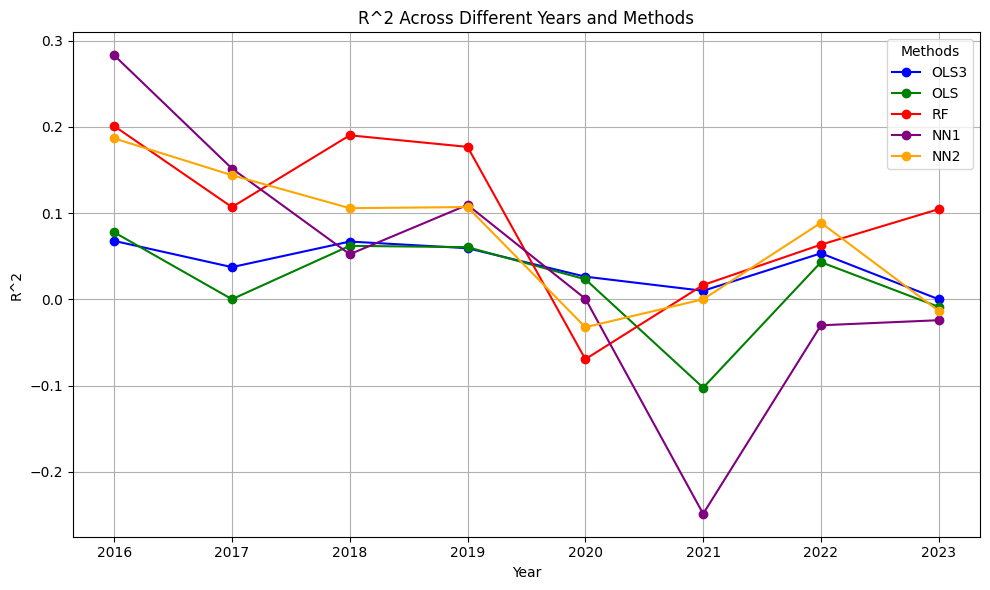

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your dataset is stored in a CSV file
df = pd.read_csv('combined_file.csv')

# Plotting R^2 across different years with different methods in different colors
plt.figure(figsize=(10, 6))

# Plot each method's R^2 across years
methods = ['OLS3', 'OLS', 'RF', 'NN1', 'NN2']
colors = ['blue', 'green', 'red', 'purple', 'orange']  # You can change the colors

for method, color in zip(methods, colors):
    plt.plot(df['Year'], df[method], label=method, color=color, marker='o')

# Add labels and title
plt.xlabel('Year')
plt.ylabel('R^2')
plt.title('R^2 Across Different Years and Methods')
plt.legend(title='Methods')

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
